---
title: Datasets and Dataloaders
---

## Introduction to Pytorch `Dataset`

For training any machine learning models we need data. Typically, this data needs to be represented in form of a PyTorch tensor in order to be fed into a model. In PyTorch, a `Dataset` is an abstract class that represents a dataset. It provides a way to access the data and defines the way the data should be processed. The `Dataset` class is an abstract class and you need to create a subclass to use it. If you are not familiar with OOPs fundamentals like abstract base class and subclass, I suggest you to read [this blog](https://aayushmnit.com/posts/2022-12-20-PythonFundamentals/Python%20OOPs%20Fundamentals.html).

The main use of a dataset in PyTorch is to provide a way to access the data that you want to use to train a machine learning model. By creating a subclass of the `Dataset` class, you can define how the data should be loaded and processed. Once you have created a `Dataset` subclass, you can use it to create a PyTorch `DataLoader`, which is an iterator that will yield batches of data from your dataset. You can then use the `DataLoader` to train a model in PyTorch.

Let's look at the `Dataset` documentation.

In [1]:
from torch.utils.data import Dataset
print(Dataset.__doc__)

An abstract class representing a :class:`Dataset`.

    All datasets that represent a map from keys to data samples should subclass
    it. All subclasses should overwrite :meth:`__getitem__`, supporting fetching a
    data sample for a given key. Subclasses could also optionally overwrite
    :meth:`__len__`, which is expected to return the size of the dataset by many
    :class:`~torch.utils.data.Sampler` implementations and the default options
    of :class:`~torch.utils.data.DataLoader`.

    .. note::
      :class:`~torch.utils.data.DataLoader` by default constructs a index
      sampler that yields integral indices.  To make it work with a map-style
      dataset with non-integral indices/keys, a custom sampler must be provided.
    


As we can see above `Dataset` is an abstract base class which requires us to implement `__getitem__` function and optionally overwrite the `__len__` method for returning the size of the dataset.

## Exercise: Creating our first custom dataset class

 In this exercise, we will continue from our previous [linear regression example](3_autograd.ipynb#creating-dummy-data) where we trained a linear regression using batch gradient descent and replace it with mini-batch gradient descent using `Dataset` and `Dataloaders`.

Let's start by importing required libraries and creating our linear data.

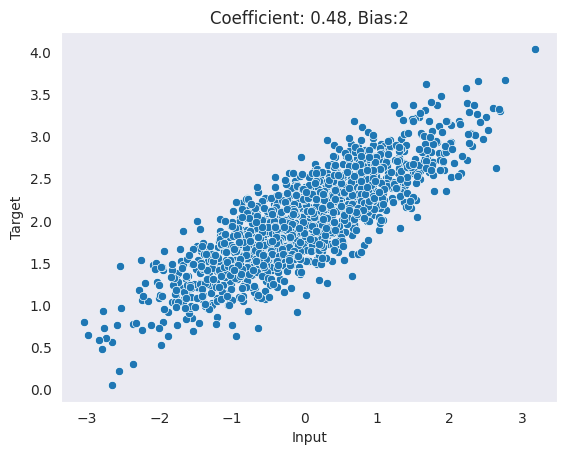

          X         y
0 -0.234216  1.901007
1 -2.030684  1.274535
2  0.651781  1.832122
3  2.014060  2.936113
4  0.829986  2.488750


In [2]:
#| code-fold: true
## Importing required functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
import seaborn as sns
import time
from IPython.display import clear_output
sns.set_style("dark")
%matplotlib inline

def plot_data(x, y, y_pred=None, label=None):
    clear_output(wait=True)
    sns.scatterplot(x = X.squeeze(), y=y)
    if y_pred is not None:
        sns.lineplot(x = X.squeeze(), y=y_pred.squeeze(), color='red')
    plt.xlabel("Input")
    plt.ylabel("Target")
    if label: 
        plt.title(label)
    plt.show()
    time.sleep(0.5)

## Generate dataset with linear property
X, y, coef = make_regression(
    n_samples=1500,
    n_features=1,
    n_informative=1,
    noise=0.3,
    coef=True,
    random_state=0,
    bias=2
)
## Converting it into a Pandas dataframe
data = pd.DataFrame({"X":X.squeeze(), "y":y})

## Visualizing the relationship b/w X and Y
plot_data(data.X, data.y, label=f"Coefficient: {coef:.2f}, Bias:{2}")

## Printing top 5 rows
print(data.head())

Let's create a custom `Dataset` class named `TabularDataset` by inheriting the `Dataset` abstract base class and implementing our `__len__` and `__getitem__` function.

:::{.callout-note}
Methods with double underscores (also known as "dunder" methods) are special methods in Python. When the `len()` function is called on an object, Python will automatically call the object's `__len__` method to get the length of the object. Similarly, when the object is indexed using the square bracket operator (e.g. `obj[key]`), Python will call the object's `__getitem__` method to retrieve the value at the specified index.
:::

In [3]:
class TabularDataset(Dataset):
    def __init__(self, data):
        self.data = data.X
        self.targets = data.y

    def __len__(self): 
        return self.data.shape[0]

    def __getitem__(self, idx):
        current_sample = self.data.iloc[idx]
        current_target = self.targets[idx]
        return {
            "X": torch.tensor(current_sample, dtype=torch.float), 
            "y": torch.tensor(current_target, dtype=torch.float)
        }

The `TabularDataset` class has three methods: `__init__`, `__len__`, and `__getitem__`.

- The `__init__` method is called when the class is instantiated and takes a pandas dataframe as an input.
- The `__len__` method returns the number of samples in the dataset.
- The `__getitem__` method returns a sample from the dataset at a given index `idx`, in the form of a dictionary with keys X and y.

We can create an object from the `TabularDataset` class using our regression example, and then call the `__len__` and`__getitem__` methods on it.

In [6]:
# create an object of the TabularDataset class
custom_dataset = TabularDataset(data)

# get the length of the dataset
size = len(custom_dataset)
print(f'Dataset size: {size} \n')

# get the sample at index 0
sample = custom_dataset[0]
print(f'Indexing on 0 index: \n {sample}')

Dataset size: 1500 

Indexing on 0 index: 
 {'X': tensor(-0.2342), 'y': tensor(1.9010)}


## Dataloaders

While training a machine learning model, it is often more efficient to pass a group of samples, or a "mini-batch," to the model at once, rather than processing one sample at a time. Additionally, we may want to reshuffle the data at the end of each epoch and use multiple threads to speed up the data loading process.

The PyTorch `DataLoader` class helps us achieve these goals by creating an iterable from our `Dataset` object. The `DataLoader` can be used to efficiently batch and shuffle the data, and it can use multiple threads to speed up the data loading process.

Let's create a dataloader object from our `TabularDataset` object.

In [183]:
from torch.utils.data import DataLoader
custom_dataloader = DataLoader(custom_dataset, batch_size=64, shuffle=True)

Now let's look at one minibatch:

In [187]:
batch = next(iter(custom_dataloader))
batch

{'X': tensor([-0.3077,  1.2761, -1.3750,  0.3675, -0.1698, -0.9571,  0.8025,  0.5990,
         -0.0493,  0.6723, -0.4685,  0.3869, -0.4524, -0.0723,  0.4608, -0.9526,
         -1.1540, -0.7615, -1.9808,  0.6169,  0.8635,  0.4573,  0.5128,  1.3710,
         -0.7579,  0.6536,  2.2436, -2.0042,  1.0963,  0.0963, -0.3596,  1.8676,
          2.2409, -1.5416, -1.6760,  0.0876, -0.8603, -0.0554, -0.2718, -0.1799,
         -0.1984, -0.1496,  0.2135, -1.0225,  0.8203,  0.1758,  1.3014, -0.8964,
         -0.8158, -0.4032,  2.7594, -2.2453, -0.8076, -1.2846,  1.0814, -0.1928,
          0.5249, -0.2008, -0.5395, -0.4059, -0.0157, -0.1378, -0.0731,  0.7557]),
 'y': tensor([1.5262, 2.3860, 1.4399, 1.9463, 1.6299, 1.3185, 2.5141, 2.1944, 1.3988,
         2.5274, 1.7082, 1.7096, 2.0795, 1.7431, 2.3721, 1.6414, 1.7229, 2.0887,
         0.5326, 2.7281, 2.0023, 2.3580, 1.7565, 3.0359, 1.8835, 1.6034, 2.7181,
         1.2389, 2.2476, 2.1065, 1.5870, 2.7240, 3.3953, 0.6919, 1.8756, 2.1122,
         1.4296,

In [190]:
print(f"Input feature shape: {batch['X'].shape}")
print(f"Target  shape: {batch['y'].shape}")

Input feature shape: torch.Size([64])
Target  shape: torch.Size([64])


As we can see above, we got our first batch of 64 data samples.

## Exercise: Linear regression with mini-batch gradient descent 

Let's get our model definition from [last chapter](./3_autograd.ipynb#define-a-linear-regression-function).

In [322]:
class Linear:
    def __init__(self, n_in, n_out):
        self.w = torch.randn(n_in, n_out).requires_grad_(True)
        self.b = torch.randn(n_out).requires_grad_(True)
        self.params = [self.w, self.b]
        
    def forward(self, x):
        return x @ self.w + self.b
    
## Initializing model
torch.manual_seed(4)
model = Linear(X.shape[1], 1)

## Making a random prediction
loss = 0
with torch.no_grad():
    for batch in iter(custom_dataloader):
        y_pred = model.forward(batch['X'].unsqueeze(-1)).numpy()
        y_true = batch['y'].numpy()
        loss += sum((y_pred.squeeze() - y_true.squeeze())**2)
print(f"MSE loss: {loss/len(custom_dataset):.4f}")

MSE loss: 7.2129


This MSE is bad considering in last chapter we were able to achieve 0.09. Let's update the previous chapter `step` function to take mini-batches.

In [312]:
def step(custom_dataloader, model, lr = 1e-3):
    ## Iterate through mini-batch
    for batch in iter(custom_dataloader):
        ## Taking one mini-batch
        y_pred = model.forward(batch['X'].unsqueeze(-1))
        y_true = batch['y']
        
        ## Calculation mean square error per min-batch
        loss = sum((y_pred.squeeze() - y_true.squeeze())**2)
    
        ## Computing gradients per mini-batch
        loss.backward()
    
        ## Updating parameters per mini-batch
        with torch.no_grad():
            for param in model.params:
                param -= lr*param.grad.data
                param.grad.data.zero_()
                
    ## Compute loss for the epoch
    loss = 0
    with torch.no_grad():
        for batch in iter(custom_dataloader):
            y_pred = model.forward(batch['X'].unsqueeze(-1))
            y_true = batch['y']
            loss += sum((y_pred.squeeze() - y_true.squeeze())**2)
    return loss/len(custom_dataset)

Let's run few epoch.

In [321]:
model = Linear(1,1)
for epoch in range(3):
    loss = step(custom_dataloader, model)
    print(f"Epoch: {epoch}, MSE: {loss:.4f}")
    
print(f"\nTrue coefficient is {coef.item():.2f} and predicted coefficient is {model.w.item():.2f}.")
print(f"True bias term is {2} and predicted coefficient is {model.b.item():.2f}.")

Epoch: 0, MSE: 0.0945
Epoch: 1, MSE: 0.0878
Epoch: 2, MSE: 0.0877

True coefficient is 0.48 and predicted coefficient is 0.47.
True bias term is 2 and predicted coefficient is 2.00.


From the results above, it appears that the model's performance improved with each epoch, as the mean squared error (MSE) consistently decreased. The performance of the model is now similar to the performance we observed in the last chapter.

## Conclusion

In PyTorch, a `Dataset` is an abstract class that represents a dataset. It provides a way to access the data and defines the way the data should be processed. The `Dataset` class is an abstract class and you need to create a subclass to use it.

A `DataLoader` is an iterator that provides access to a dataset. It can be used to efficiently batch and shuffle the data, and it can use multiple threads to speed up the data loading process.

The `Dataset` and `DataLoader` classes are an important part of PyTorch's data loading and processing functionality. They are often used together to train machine learning models, because they provide a convenient and efficient way to access and process data.

## References

- [Pytorch tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
- [Pytorch 101: An applied tutorial - Abhishek Thakur Youtube channel](https://www.youtube.com/watch?v=oWq6aVv5mC8&list=PL98nY_tJQXZln8spB5uTZdKN08mYGkOf2&index=3)